## OnionOrNot Using USE & Classifier DL Approach (Part 2)
  - The pipeline also includes a lemmatizer, stopword remover, & spell checker (among other stages)

Project Objective: to correctly classify if a title is for an Onion news article or not.  

Dataset Source: https://www.kaggle.com/datasets/chrisfilo/onion-or-not

##### Import Necessary Libraries

In [0]:
import pandas as pd

import pyspark
from pyspark.sql.types import StructType, StructField, StringType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Versions of Libraries, Modules, Frameworks Used in This Project

In [0]:
print("Spark NLP version".rjust(24), sparknlp.version())
print(f"Apache Spark version:".rjust(24), spark.version)

       Spark NLP version 4.2.4
   Apache Spark version: 3.2.1


#### Create Functions Used Throughout This Project

##### Create Function to Ingest Dataset

In [0]:
def ingest_dataset(file_location: str, schema: StructType) -> pyspark.sql.dataframe.DataFrame:
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    
    dataset = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .schema(schema) \
      .load(file_location)
    
    dataset = dataset.na.drop(how='any')
    
    return dataset

##### Create Function to Remove Class Imbalance

In [0]:
def balance_dataset(dataset, unique_label_values, new_schema, samples = 20000, label_col = "label"):
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))
        
        ratio = round(samples/temp_df.count(),4)
        # sample it to desired number of samples
        if ratio > 1.0:
            # Oversample
            temp_df = temp_df.sample(True, ratio, seed=42)
        elif ratio < 1.0:
            # Undersample
            temp_df = temp_df.sample(False, ratio, seed=42)
        elif ratio == 1.0:
            # Just use the existing dataframe
            pass
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

##### Metrics Evaluation Function

In [0]:
def metrics_eval(prediction: pd.Series, \
                 label: pd.Series, \
                 model_name: str, \
                 label_values: []\
                ) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
       & F1-score, among others)
    - Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
    
    print("-------------------------------------------------------------------------------------")
    print("| " + ("The %s Model" % model_name).center(81) + " |")
    print("-------------------------------------------------------------------------------------")
    print("| " + f"Classification Report for the {model_name} Model".center(81) + " |")
    print("-------------------------------------------------------------------------------------\n")

    if label_values != []:
        report = classification_report(label, prediction, zero_division=1, target_names=label_values)
    else:
        report = classification_report(label, prediction, zero_division=1)
    print(report)

    print("-------------------------------------------------------------------------------------")

    print("| " + f"Confusion Matrix for the {model_name} Model".center(81) + " |")
    cm = confusion_matrix(label, prediction)
    
    if label_values != []:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    else:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()

    print("-------------------------------------------------------------------------------------")

#### Prepare Data For Model

##### Ingest & Preprocess Data

In [0]:
data_file = "/FileStore/tables/OnionOrNot.csv"

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = ingest_dataset(data_file, orig_schema)

df = df.where("label==0 or label==1")

df = df.na.drop() 

df = df.withColumn("text_length", F.size(F.split(F.col('text'), ' ')))

display(df)

##### Trim Overly Lengthy Samples from Dataset & Final Preprocessing/Cleanup

In [0]:
df = df.filter(df.text_length < 40)
df = df.drop(df.text_length)

print(f"There are {df.count()} samples in this dataset at this time.\n")
df.printSchema()

There are 23843 samples in this dataset at this time.

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)



##### Remove Class Imbalance

In [0]:
bal_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = balance_dataset(df, ["0", "1"], bal_schema, samples = 14800, label_col = "label")

##### Print Number of Samples in Dataset & Dataset Schema

In [0]:
df.printSchema()
df.count()

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)

Out[12]: 29764

##### Split Dataset into Training & Testing Dataset

In [0]:
train_ds, test_ds = df.randomSplit(weights=[0.80, 0.20], seed=42)

train_ds = train_ds.persist()
test_ds = test_ds.persist()

print(train_ds.count())
print(test_ds.count())

23779
5985


##### Basic Values/Constants

In [0]:
NUM_OF_EPOCHS = 16
BATCH_SIZE = 64

##### Define Piepline Stages

In [0]:
# document assembler
doc = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

# Sentence Detector
sentence = SentenceDetectorDLModel.pretrained("sentence_detector_dl", "en")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

# tokenizer
doc_to_token = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

# spellchecker
sw_cleaner = StopWordsCleaner() \
        .setInputCols(["token"]) \
        .setOutputCol("cleanTokens") \
        .setCaseSensitive(False)

# Spell Checker via Context Spell Checker Model
spell_checker = ContextSpellCheckerModel \
    .pretrained() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("spell") \

# lemmatizer
lemma = LemmatizerModel.pretrained() \
        .setInputCols(["spell"]) \
        .setOutputCol("lemma")

# Token Assembler
token_to_doc = TokenAssembler() \
        .setInputCols(["document", "lemma"]) \
        .setOutputCol("clean_text")

# Universal Sentence Encoder
use = UniversalSentenceEncoder.pretrained() \
        .setInputCols(["clean_text"])\
        .setOutputCol("sentence_embeddings")

doc_clf = ClassifierDLApproach() \
    .setInputCols("sentence_embeddings") \
    .setOutputCol("class") \
    .setLabelColumn("label") \
    .setBatchSize(BATCH_SIZE) \
    .setMaxEpochs(NUM_OF_EPOCHS)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
spellcheck_dl download started this may take some time.
Approximate size to download 95.1 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


##### Build Pipeline for Training

In [0]:
nlp_clf_pipeline = Pipeline().setStages([
    doc,
    sentence,
    doc_to_token,
    sw_cleaner,
    spell_checker,
    lemma,
    token_to_doc,
    use,
    doc_clf
])

##### Fit/Train Model

In [0]:
nlp_clf_model = nlp_clf_pipeline.fit(train_ds)

##### Predictions Using Testing Dataset

In [0]:
predictions = nlp_clf_model.transform(test_ds)

##### Convert Predictions to Pandas DataFrame & Only Return Necessary Features

In [0]:
predictions_in_pandas = predictions.select(F.col('label').alias("ground_truth"), \
                                           F.col("class.result").alias("prediction")).toPandas()

predictions_in_pandas['prediction'] = predictions_in_pandas['prediction'].apply(lambda x : x[0])

display(predictions_in_pandas)

ground_truth,prediction
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0


##### Calculate & Display Classification Report

-------------------------------------------------------------------------------------
|                 The Onion Or Not USE & CLF DL & Other Stages Model                |
-------------------------------------------------------------------------------------
|    Classification Report for the Onion Or Not USE & CLF DL & Other Stages Model   |
-------------------------------------------------------------------------------------

              precision    recall  f1-score   support

   Not Onion       0.86      0.86      0.86      2975
       Onion       0.86      0.86      0.86      3010

    accuracy                           0.86      5985
   macro avg       0.86      0.86      0.86      5985
weighted avg       0.86      0.86      0.86      5985

-------------------------------------------------------------------------------------
|      Confusion Matrix for the Onion Or Not USE & CLF DL & Other Stages Model      |
----------------------------------------------------------------------

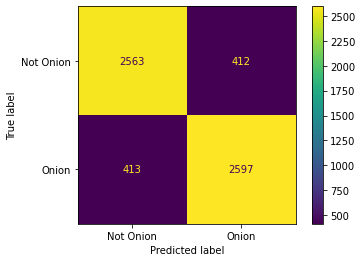

In [0]:
metrics_eval(predictions_in_pandas['ground_truth'], predictions_in_pandas['prediction'], "Onion Or Not USE & CLF DL & Other Stages", ["Not Onion", "Onion"])

##### Unpersist Datasets & End Spark Session

In [0]:
train_ds = train_ds.unpersist()
test_ds = test_ds.unpersist()
spark.stop()

### Notes & Other Takeaways From This Project
****
- Oddly enough, this project did worse than the project that only used the document assembler and universal sentence encoder prior to running the Classifier (DL Approach)
****